In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

In [ ]:
# Load the dataset
file_path = '/content/drive/My Drive/Dataset/tweets.csv'
df = pd.read_csv(file_path, encoding='latin-1', header=None)  # adjust encoding if necessary

# Since the dataset may not have headers, let's define them based on typical tweet datasets.
# Adjust these if you have specific headers:
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# Initial Data Exploration
print("Dataset Head:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nDataset Description (Numerical Columns):")
print(df.describe())

# Class Balance Check
print("\nClass Balance (Sentiment Labels):")
print(df['target'].value_counts())

Dataset Head:
   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype

In [ ]:
# Download NLTK resources if not already downloaded
nltk.download('stopwords')

# Text Cleaning Function
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters and punctuation
    text = re.sub(r'\W', ' ', text)
    # Lowercase the text
    text = text.lower()
    return text

# Apply text cleaning
df['cleaned_text'] = df['text'].apply(clean_text)

# Stop Words Removal
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Stemming
stemmer = SnowballStemmer("english")
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Tokenization using Keras Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
df['text_sequences'] = tokenizer.texts_to_sequences(df['cleaned_text'])

# Inspect the result
print("\nCleaned and Tokenized Text Sample:")
print(df[['text', 'cleaned_text', 'text_sequences']].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.



Cleaned and Tokenized Text Sample:
                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                        cleaned_text  \
0  switchfoot bummer shoulda got david carr third...   
1  upset updat facebook text might cri result sch...   
2  kenichan dive mani time ball manag save 50 res...   
3                    whole bodi feel itchi like fire   
4                      nationwideclass behav mad see   

                                      text_sequences  
0        [15967, 1061, 3153, 11, 643, 7737, 1709, 3]  
1  [612, 224, 437, 364, 208, 238, 1004, 77, 9, 19...  
2  [22601, 3750, 230, 10, 850, 717, 516, 980, 355...  
3                       [345, 662, 21, 2616, 6, 873]  
4              

In [ ]:
# --- TF-IDF Vectorization ---
# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit features to top 5000 terms

# Fit and transform the cleaned text
tfidf_features = tfidf_vectorizer.fit_transform(df['cleaned_text']).toarray()

# Print shape to verify
print("\nTF-IDF Features Shape:", tfidf_features.shape)

# --- Word Embeddings (Using GloVe or Word2Vec) ---
# Load pre-trained GloVe embeddings
embedding_index = {}
embedding_dim = 100  # Adjust to 50, 100, 200, or 300 based on GloVe model

# Make sure to download the GloVe embeddings separately if not available locally
glove_file_path = '/content/drive/My Drive/Dataset/glove.6B.100d.txt'  # Update to the correct path
with open(glove_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefficients = np.array(values[1:], dtype='float32')
        embedding_index[word] = coefficients

# Prepare embedding matrix
tokenizer = Tokenizer(num_words=5000)  # Limit vocabulary to top 5000 words
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
word_index = tokenizer.word_index
padded_sequences = pad_sequences(sequences, maxlen=100)  # Pad sequences for uniform length

vocab_size = min(5000, len(word_index)) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i < 5000:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Define an Embedding layer without the input_length argument
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], trainable=False)

# Print sample sequences to verify
print("\nSample Padded Sequence:")
print(padded_sequences[0])


TF-IDF Features Shape: (1600000, 5000)

Sample Padded Sequence:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 1061 3153   11  643
 1709    3]


In [ ]:
# # Assuming we want to use the TF-IDF features for traditional ML models
# X_tfidf = tfidf_features
# y = df['target']  # Assuming 'target' is the sentiment label column

# # Split TF-IDF features into train and test sets
# X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# print("\nTF-IDF Train and Test Shapes:")
# print("X_train_tfidf:", X_train_tfidf.shape)
# print("X_test_tfidf:", X_test_tfidf.shape)
# print("y_train:", y_train.shape)
# print("y_test:", y_test.shape)

# # Alternatively, if using Word Embeddings, split the padded sequences
# X_embeddings = padded_sequences

# # Split embedding sequences into train and test sets
# X_train_embeddings, X_test_embeddings, y_train_embed, y_test_embed = train_test_split(X_embeddings, y, test_size=0.2, random_state=42)

# print("\nEmbedding Train and Test Shapes:")
# print("X_train_embeddings:", X_train_embeddings.shape)
# print("X_test_embeddings:", X_test_embeddings.shape)
# print("y_train_embed:", y_train_embed.shape)
# print("y_test_embed:", y_test_embed.shape)

In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
# import numpy as np
# import gc

# # Load a subset of the data for testing (e.g., 20%)
# file_path = '/content/drive/My Drive/Dataset/tweets.csv'
# df = pd.read_csv(file_path, encoding='latin-1', header=None)
# df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']

# # --- TF-IDF Vectorization ---
# # Limit features to top 1000 terms to reduce memory usage
# tfidf_vectorizer = TfidfVectorizer(max_features=1000)
# tfidf_features = tfidf_vectorizer.fit_transform(df_sample['text'])  # Keep as sparse matrix

In [ ]:
# # Sample 20% of the data
# df_sample = df.sample(frac=0.2, random_state=42)
# print("Sample Data Shape:", df_sample.shape)

# # Define target labels
# y_sample = df_sample['target']

# # Split TF-IDF features into train and test sets (keeping sparse format)
# X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_features, y_sample, test_size=0.2, random_state=42)

# print("\nTF-IDF Train and Test Shapes:")
# print("X_train_tfidf:", X_train_tfidf.shape)
# print("X_test_tfidf:", X_test_tfidf.shape)
# print("y_train:", y_train.shape)
# print("y_test:", y_test.shape)

# # --- Word Embeddings (Using GloVe) ---
# # Tokenizer settings for embedding-based models
# tokenizer = Tokenizer(num_words=5000)  # Limit vocabulary to top 5000 words
# tokenizer.fit_on_texts(df_sample['text'])
# sequences = tokenizer.texts_to_sequences(df_sample['text'])

# # Pad sequences to a shorter length (e.g., 50)
# padded_sequences = pad_sequences(sequences, maxlen=50)

# # Split embedding sequences into train and test sets
# X_train_embeddings, X_test_embeddings, y_train_embed, y_test_embed = train_test_split(padded_sequences, y_sample, test_size=0.2, random_state=42)

# print("\nEmbedding Train and Test Shapes:")
# print("X_train_embeddings:", X_train_embeddings.shape)
# print("X_test_embeddings:", X_test_embeddings.shape)
# print("y_train_embed:", y_train_embed.shape)
# print("y_test_embed:", y_test_embed.shape)

# # Free up memory by deleting large objects
# del df, df_sample, tfidf_features, sequences
# gc.collect()


In [ ]:
import gc

# Define target labels
y = df['target']

# Split TF-IDF features into train and test sets (keeping sparse format)
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(tfidf_features, y, test_size=0.2, random_state=42)

print("\nTF-IDF Train and Test Shapes:")
print("X_train_tfidf:", X_train_tfidf.shape)
print("X_test_tfidf:", X_test_tfidf.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

# --- Word Embeddings (Using GloVe) ---
# Tokenizer settings for embedding-based models
tokenizer = Tokenizer(num_words=5000)  # Limit vocabulary to top 5000 words
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

# Pad sequences to a specified length (e.g., 100)
padded_sequences = pad_sequences(sequences, maxlen=100)

# Split embedding sequences into train and test sets
X_train_embeddings, X_test_embeddings, y_train_embed, y_test_embed = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

print("\nEmbedding Train and Test Shapes:")
print("X_train_embeddings:", X_train_embeddings.shape)
print("X_test_embeddings:", X_test_embeddings.shape)
print("y_train_embed:", y_train_embed.shape)
print("y_test_embed:", y_test_embed.shape)

# Free up memory by deleting large objects not in use
del sequences, df['text'], tfidf_features
gc.collect()



TF-IDF Train and Test Shapes:
X_train_tfidf: (1280000, 5000)
X_test_tfidf: (320000, 5000)
y_train: (1280000,)
y_test: (320000,)

Embedding Train and Test Shapes:
X_train_embeddings: (1280000, 100)
X_test_embeddings: (320000, 100)
y_train_embed: (1280000,)
y_test_embed: (320000,)


0

In [ ]:
# Import the LinearSVC model from scikit-learn
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the LinearSVC model with a specified regularization parameter C
# The C parameter controls the regularization strength
# Higher values of C lead to less regularization, while lower values increase regularization
svm = LinearSVC(C=1.0, random_state=42)  # Adjust C if needed

# Train the model on the training data
# This step fits the SVM model using the TF-IDF features and the target labels
print("Training the SVM model...")
svm.fit(X_train_tfidf, y_train)

# After training, we can evaluate the model on the test data
# Make predictions on the test set
y_pred = svm.predict(X_test_tfidf)

# Calculate accuracy of the model on the test set
accuracy = accuracy_score(y_test, y_pred)
print("SVM Model Accuracy on Test Set:", accuracy)

# Generate a detailed classification report
# This includes precision, recall, and F1-score for each class
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Compute and display the confusion matrix
# This helps us understand the number of correct and incorrect predictions for each class
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)

Training the SVM model...
SVM Model Accuracy on Test Set: 0.767259375

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.74      0.76    159494
           4       0.75      0.79      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000


Confusion Matrix:
 [[118050  41444]
 [ 33033 127473]]



SVM Model Accuracy on Test Set: 76.73%

Classification Report:

              precision    recall  f1-score   support

    Negative       0.78      0.74      0.76    159494
    Positive       0.75      0.79      0.77    160506

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000


Confusion Matrix:

          Predicted Negative  Predicted Positive
Negative              118050               41444
Positive               33033              127473


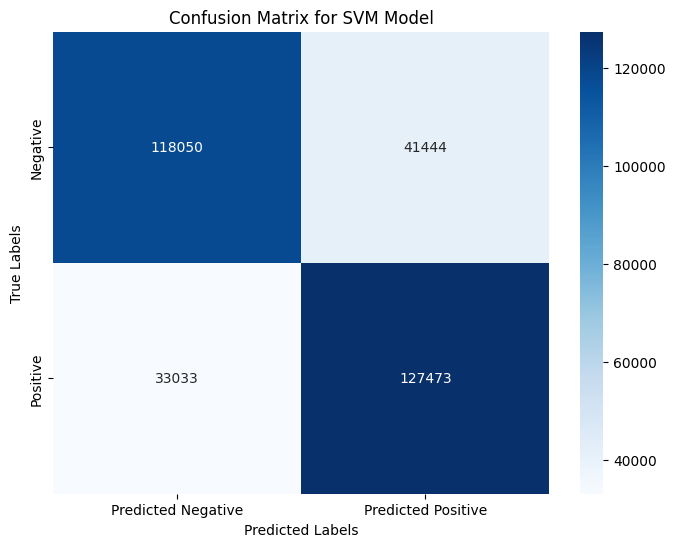

In [ ]:
# Print SVM Model Accuracy on Test Set
print(f"\nSVM Model Accuracy on Test Set: {accuracy:.2%}")

# Detailed classification report
from sklearn.metrics import classification_report
classification_report_str = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'])
print("\nClassification Report:\n")
print(classification_report_str)

# Confusion Matrix with Labels
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Negative', 'Positive'], columns=['Predicted Negative', 'Predicted Positive'])

print("\nConfusion Matrix:\n")
print(conf_matrix_df)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix for SVM Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {'C': [0.1, 0.5, 1, 5, 10]}
grid_search = GridSearchCV(LinearSVC(random_state=42), param_grid, cv=3, scoring='accuracy')

# Fit the grid search on the training data
print("Performing hyperparameter tuning...")
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameter and score
print("Best parameter (C):", grid_search.best_params_['C'])
print("Best cross-validation accuracy:", grid_search.best_score_)

# Update the model with the best found parameter
svm = grid_search.best_estimator_


Performing hyperparameter tuning...
Best parameter (C): 0.1
Best cross-validation accuracy: 0.7668382810635581


In [ ]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation and calculate the mean accuracy
cv_scores = cross_val_score(svm, X_train_tfidf, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean Cross-Validation Accuracy:", cv_scores.mean())

Cross-Validation Accuracy Scores: [0.76726562 0.7669375  0.7668125  0.76684375 0.76760938]
Mean Cross-Validation Accuracy: 0.76709375


In [ ]:
# Check column names to confirm where the original text is stored
print("Columns in DataFrame:", df.columns)

# Ensure the correct column name for original text
if 'text' in df.columns:
    text_column = 'text'
elif 'cleaned_text' in df.columns:  # Use cleaned text if available
    text_column = 'cleaned_text'
else:
    raise KeyError("No suitable column for text found in the DataFrame. Check column names.")

# Align original text with test labels
X_test_original = df.loc[y_test.index, text_column]

# Extract misclassified indices
misclassified_indices = (y_test != y_pred)

# Extract misclassified samples
misclassified_samples = X_test_original[misclassified_indices]
misclassified_labels = y_test[misclassified_indices]
predicted_labels = y_pred[misclassified_indices]

# Combine into a DataFrame for review
misclassified_df = pd.DataFrame({
    'Text': misclassified_samples,
    'True Label': misclassified_labels,
    'Predicted Label': predicted_labels
})

# Display some examples
print("\nExamples of Misclassified Tweets:")
print(misclassified_df.head(10))


Columns in DataFrame: Index(['target', 'id', 'date', 'flag', 'user', 'cleaned_text',
       'text_sequences'],
      dtype='object')

Examples of Misclassified Tweets:
                                                      Text  True Label  \
541200                           chrishasboob ahhh hope ok           0   
750                    misstoriblack cool tweet app razr 2           0   
766711   tiannachao know famili drama lame hey next tim...           0   
705995                                upper airway problem           0   
1380171        perezhilton zach make pee sit grown gay man           4   
820010   lilpecan oh realli great small blizzard also c...           4   
1586084  feel quit sleepi today wish could stay bed tod...           4   
171708                            day pass slowli day rawr           0   
305246   rocdoogi admit mayb feel better tomorrow yo 4 ...           0   
1541646                                   get ex back work           4   

         Predicte

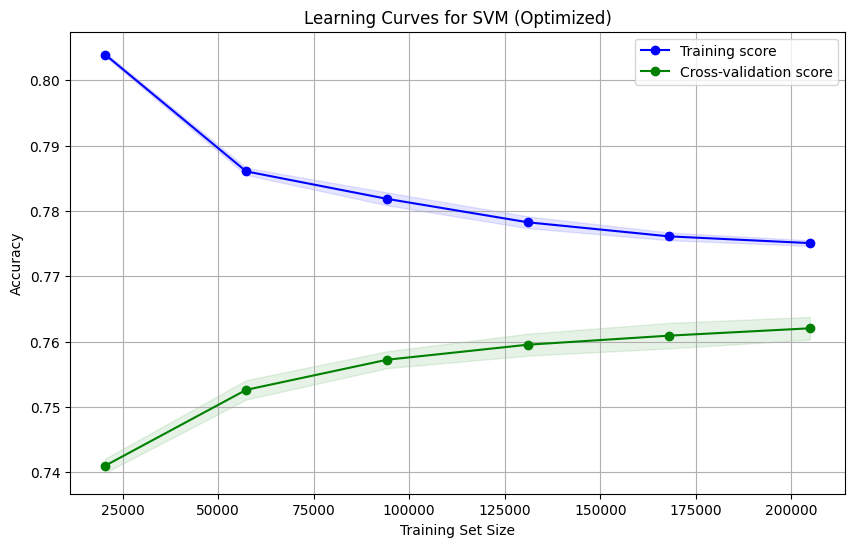

In [ ]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp

# Optional: Subsample the data for faster computation
subsample_ratio = 0.2  # Use 20% of the data for learning curves
subsample_size = int(len(y_train) * subsample_ratio)

# Randomly select a subset of the training data
indices = np.random.choice(X_train_tfidf.shape[0], subsample_size, replace=False)
X_train_subsample = X_train_tfidf[indices]
y_train_subsample = np.array(y_train)[indices]

# Reduce train_sizes for efficient computation
train_sizes = np.linspace(0.1, 1.0, 6)  # Fewer points for learning curve

# Calculate learning curves
train_sizes, train_scores, test_scores = learning_curve(
    svm, X_train_subsample, y_train_subsample, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=train_sizes
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curves for SVM (Optimized)")
plt.legend(loc="best")
plt.grid()
plt.show()
